# **02 Model evolution along a *P*–*T*-path**
---

This notebook shows you how to:
1. Model the system evolution of a rock along a predefined *P*–*T*-trajectory, by:
    * Automatically calling repeated Theriak minimisations.
    * Forwarding of bulk rock composition.
2. Visualisation of mineral modes an compostion as a function of *P* and *T*.
3. Fractionated phases for modelling along a *P*–*T*-path with evolving reactive bulk rock composition.

**Requirements:**
- python >= 3.10
*with the following packages installed:*
- pytheriak
- matplotlib
- ...

*Theriak-Domino back-end:*
- A working Theriak-Domino installation.
- Thermodynamic databases to use with Theriak in the working directory.
---

### Import all required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pytheriak import wrapper

### Initiate a TherCaller-object.
The argument `programs_dir` must be set to the directory of your Theriak_Domino installation.

In [2]:
theriak = wrapper.TherCaller(programs_dir="C:\\TheriakDominoWIN\\Programs",
                             database="td-ds62-mb50-v07.txt",
                             theriak_version="v2023.03.06")

### Set model parameter
*P*–*T*-path from Gerya et al. (2002) in Vho et al. (2020) Fig. 2 (https://doi.org/10.5194/se-11-307-2020).\
TODO: Add in refenrence to Thorstens P-T-path extraction tool.\
\
*Bulk rock compositions of unaltered and altered metabaslat in Vho et al. (2020) (https://doi.org/10.5194/se-11-307-2020).*


In [3]:
pt_path = np.loadtxt(Path("PTpath_Gerya2002.txt")).T
bulk_MORB = "SI(44.78)TI(1.12)AL(15.37)FE(7.74)MN(0.00)MG(10.03)CA(10.83)NA(4.80)K(0.18)H(30.64)O(?)O(1)"
bulk_AOC = "SI(41.37)TI(0.76)AL(16.54)FE(4.76)MN(0.00)MG(8.97)CA(12.46)NA(3.61)K(0.64)H(35.28)O(?)O(1)"

Create lists to store the data we want to track along the *P*–*T*-path.

In [4]:
lawsonite_stable = []
lawsonite_vol_percent = []
lawsonite_dG = []
# to have complete data, store all rocks along PT path
rocks = []

Loop over temperature and pressure pairs in of the *P*–*T*-path.

In [5]:
for temperature, pressure in pt_path:
    rock, element_list = theriak.minimisation(pressure, temperature, bulk_MORB, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names
    # when "law" is in the list of mineral names, it is stable
    lawsonite_stable.append(law_stable)

    # if lawsonite is stable, store its volume percent, delta G is None in that case
    if law_stable:
        law_idx = mineral_names.index("law")
        lawsonite_vol_percent.append(rock.mineral_assemblage[law_idx].vol_percent)
        lawsonite_dG.append(None)
    # if lawsonite is not stable, store its delta G, volume percent is None in that case
    else:
        lawsonite_vol_percent.append(None)
        lawsonite_dG.append(rock.mineral_delta_G["law"])

    rocks.append(rock)

All the data lists, pressure and temperature are combined into a pandas DataFrame.

In [6]:
laws_in_MORB = pd.DataFrame({"Temperature": pt_path[:, 0],
                             "Pressure": pt_path[:, 1],
                             "Pressure_kbar": pt_path[:, 1] / 1000,
                             "Lawsonite stable": lawsonite_stable,
                             "Lawsonite vol %": lawsonite_vol_percent,
                             "Lawsonite dG": lawsonite_dG})

A DataFrame allows user-friendly spreadsheet like data visualisation.
Look at the first and last entries with `head()` and `tails()`.

In [7]:
laws_in_MORB.head()

,Temperature,Pressure,Pressure_kbar,Lawsonite stable,Lawsonite vol %,Lawsonite dG
0,350.000,12965.204236,12.965204,True,19.0384,NaN
1,373.625,14417.549168,14.417549,True,19.5503,NaN
2,398.125,15930.408472,15.930408,True,24.9875,NaN
3,420.000,16777.609682,16.777610,True,26.7180,NaN
4,439.250,17534.039334,17.534039,True,26.2032,NaN


In [8]:
laws_in_MORB.tail()

,Temperature,Pressure,Pressure_kbar,Lawsonite stable,Lawsonite vol %,Lawsonite dG
13,619.500,23464.447806,23.464448,False,NaN,986.418
14,640.500,24069.591528,24.069592,False,NaN,1537.670
15,662.375,24765.506808,24.765507,False,NaN,2366.970
16,681.625,25340.393343,25.340393,False,NaN,3157.740
17,700.000,25975.794251,25.975794,False,NaN,3809.070


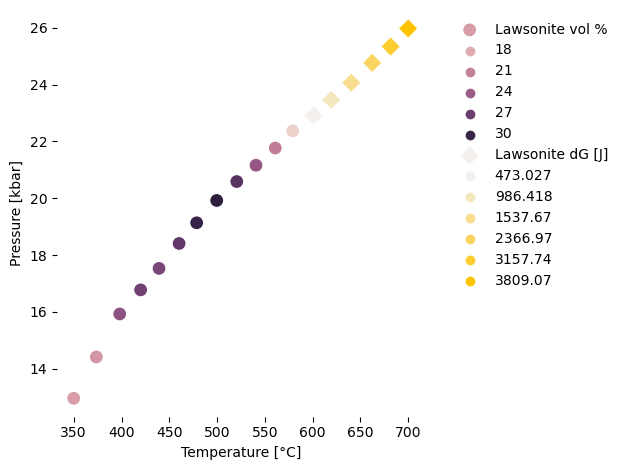

In [9]:
fig, axs = plt.subplots()

sns.scatterplot(data=laws_in_MORB,
                x="Temperature",
                y="Pressure_kbar",
                hue="Lawsonite vol %",
                s=100,
                label="Lawsonite vol %",
                ax=axs)

sns.scatterplot(data=laws_in_MORB,
                x="Temperature",
                y="Pressure_kbar",
                palette=sns.color_palette("light:#FFC300"),
                hue="Lawsonite dG",
                s=100,
                marker="D",
                label="Lawsonite dG [J]",
                ax=axs)

axs.set_xlabel("Temperature [°C]")
axs.set_ylabel("Pressure [kbar]")

axs.legend(bbox_to_anchor=(1.05, 1), frameon=False)

axs.set_frame_on(False)

fig.tight_layout()

However, from the petrography of lawsonite-bearing blueschists and eclogites we now that lawsonite tends to form big porphyroblasts. Equilibration of such porphyroblasts is believed to often be kinetically inhibited. Like this the elements bound in the lawsonite is effectively removed from the reactive bulk rock compostion.\

To account for this in our model we must update our bulk rock compostion if a fractionating (porphyroblast-forming) phase has formed.

In [10]:
def bulk_from_compositionalvector(composition: list | np.ndarray, element_list: list | np.ndarray):
    bulk = ""
    for moles, element in zip(composition, element_list):
        bulk += element
        bulk += "(" + str(moles) + ")"

    return bulk

In [13]:
lawsonite_stable_fract = []
garnet_stable_fract = []

lawsonite_vol_percent_fract = [0]
garnet_vol_percent_fract = [0]

lawsonite_dG_fract = []

rocks_fract = []

# list to track reacting volume of system with fractionation
reactive_vol_fract = [1]

# these arrays take care of the absolute moles for fractionation calculations
# initialize with 0
lawsonite_moles = np.array([np.zeros(len(element_list))])
garnet_moles = np.array([np.zeros(len(element_list))])
# initialize with the bulk composition of MORB
reactive_bulk_moles = np.array([rocks[0].bulk_composition_moles])

In [14]:
for temperature, pressure in pt_path:
    input_bulk = bulk_from_compositionalvector(reactive_bulk_moles[-1], element_list)

    rock, element_list = theriak.minimisation(pressure, temperature, input_bulk, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names

    if not law_stable:
        # change the input (reactive) bulk to include lawsonite
        input_bulk = bulk_from_compositionalvector(reactive_bulk_moles[-1] + lawsonite_moles[-1], element_list)
        rock_incl_law, element_list = theriak.minimisation(pressure, temperature, input_bulk, return_failed_minimisation=True)

        # look for lawsonite in the names of the mineral assemblage
        mineral_names_incl_law = [mineral.name for mineral in rock_incl_law.mineral_assemblage]
        law_stable = "law" in mineral_names_incl_law

        if law_stable:
            print(f"Lawsonite, got restabilised at {temperature:.0f} °C and {pressure:.0f} bar".format(temperature, pressure))

        else:
            rock = rock_incl_law
            mineral_names = mineral_names_incl_law

    lawsonite_stable_fract.append(law_stable)

    # look for garnet in the names of the mineral assemblage
    # all possible solutions (all starting with "GRT_") must be checked
    garnet_stable = len([mineral for mineral in mineral_names if mineral.startswith("GRT_")]) > 0
    # when "GRT_" is in the list of mineral names, it is stable
    garnet_stable_fract.append(garnet_stable)

    # append data of interest to lists
    if garnet_stable:
        garnet_idx = mineral_names.index([mineral for mineral in mineral_names if mineral.startswith("GRT_")][0])
        garnet_vol_percent = rock.mineral_assemblage[garnet_idx].vol_percent
        # correct for fraction of reacting volume
        garnet_vol_percent = garnet_vol_percent * reactive_vol_fract[-1]
        garnet_vol_percent_fract.append(garnet_vol_percent_fract[-1] + garnet_vol_percent)

        # add the moles of garnet to the array
        new_garnet_moles = rock.mineral_assemblage[garnet_idx].composition_moles
        garnet_moles = np.append(garnet_moles, [garnet_moles[-1] + new_garnet_moles], axis=0)

    else:
        garnet_vol_percent = 0
        garnet_vol_percent_fract.append(garnet_vol_percent_fract[-1])

        garnet_moles = np.append(garnet_moles, [garnet_moles[-1]], axis=0)


    if law_stable:
        law_idx = mineral_names.index("law")
        law_vol_percent = rock.mineral_assemblage[law_idx].vol_percent
        # correct for fraction of reacting volume
        law_vol_percent = law_vol_percent * reactive_vol_fract[-1]
        lawsonite_vol_percent_fract.append(lawsonite_vol_percent_fract[-1] + law_vol_percent)

        # add the moles of lawsonite to the array
        new_lawsonite_moles = rock.mineral_assemblage[law_idx].composition_moles
        lawsonite_moles = np.append(lawsonite_moles, [lawsonite_moles[-1] + new_lawsonite_moles], axis=0)

        lawsonite_dG_fract.append(None)

    else:
        law_vol_percent = 0
        lawsonite_vol_percent_fract.append(0)

        lawsonite_moles = np.append(lawsonite_moles, [lawsonite_moles[-1]], axis=0)

        lawsonite_dG_fract.append(rock.mineral_delta_G["law"])

    # update reactive volume
    reactive_vol_fract.append(reactive_vol_fract[-1] - law_vol_percent - garnet_vol_percent)

    # fractionate the bulk composition
    reactive_bulk_moles = np.append(reactive_bulk_moles, [reactive_bulk_moles[-1] - lawsonite_moles[-1] - garnet_moles[-1]], axis=0)

    398.12500000000006    15930.408472012103
1   O(95.22575499999999)SI(31.372151000000002)TI(1.12)AL(1.9621509999999978)FE(7.74)MG(10.03)CA(4.126075)NA(4.8)K(0.18)H(3.824301)    *
Lawsonite, got restabilised at 398 °C and 15930 bar


ValueError: 'law' is not in list

In [30]:
# initiate list for lws and grt volumes with 0
lawsonite_vol = [0]
garnet_vol = [0]

reactive_bulk = bulk_MORB

for temperature, pressure in pt_path:
    rock, element_list = theriak.minimisation(pressure, temperature, reactive_bulk, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names
    lawsonite_stable.append(law_stable)

    # for garnet all possible solutions (all starting with "GRT_") must be checked
    grt_stable = len([name for name in mineral_names if str.startswith(name, "GRT_")]) != 0
    garnet_stable.append(grt_stable)

    if law_stable:
        law_idx = mineral_names.index("law")
        lawsonite_vol_crystallised = (rock.mineral_assemblage[law_idx].vol)
        lws_composition_moles = np.array(rock.mineral_assemblage[law_idx].composition_moles)

        lawsonite_dG.append(None)


    else:
        lawsonite_vol_crystallised = 0
        lawsonite_dG.append(dict(rock.mineral_delta_G)["law"])
        lws_composition_moles = np.zeros(len(element_list))

    if grt_stable:
        grt_idx = mineral_names.index([name for name in mineral_names if str.startswith(name, "GRT_")][0])
        garnet_vol_crystallised = (rock.mineral_assemblage[grt_idx].vol)
        grt_composition_moles = np.array(rock.mineral_assemblage[grt_idx].composition_moles)

    else:
        garnet_vol_crystallised = 0
        grt_composition_moles = np.zeros(len(element_list))

    rock_vol = sum([mineral.vol for mineral in rock.mineral_assemblage])
    lawsonite_vol_percent.append((lawsonite_vol_crystallised + lawsonite_vol[-1]) / (rock_vol + lawsonite_vol[-1] + garnet_vol[-1]) * 100)
    garnet_vol_percent.append((garnet_vol_crystallised + garnet_vol[-1]) / (rock_vol + lawsonite_vol[-1] + garnet_vol[-1]) * 100)

    lawsonite_vol.append(lawsonite_vol_crystallised + lawsonite_vol[-1])
    garnet_vol.append(garnet_vol_crystallised + garnet_vol[-1])

    # fractionate bulk
    bulk = np.array(rock.bulk_composition_moles)
    reactive_bulk = bulk_from_compositionalvector(bulk - lws_composition_moles - grt_composition_moles, element_list)
    rocks.append(rock)

# drop first entries in lawsonite and garnet volume lists
lawsonite_vol = lawsonite_vol[1:]
garnet_vol = garnet_vol[1:]

    478.62500000000006    19137.67019667171
1   O(108.084078)SI(34.143815000000004)TI(1.12)AL(4.733815)FE(7.74)MG(10.03)CA(5.511908)NA(4.8)K(0.18)H(9.367631999999999)    *


In [36]:
laws_in_MORB_fractionated = pd.DataFrame({"Temperature": pt_path[:, 0],
                             "Pressure": pt_path[:, 1],
                             "Lawsonite stable": lawsonite_stable,
                             "Lawsonite vol %": lawsonite_vol_percent,
                             "Lawsonite dG": np.float_(lawsonite_dG)})

In [38]:
# remove entries of failed minimisations
laws_in_MORB_fractionated = laws_in_MORB_fractionated[laws_in_MORB_fractionated["Temperature"] != 478.62500000000006]

<Axes: xlabel='Temperature', ylabel='Pressure'>

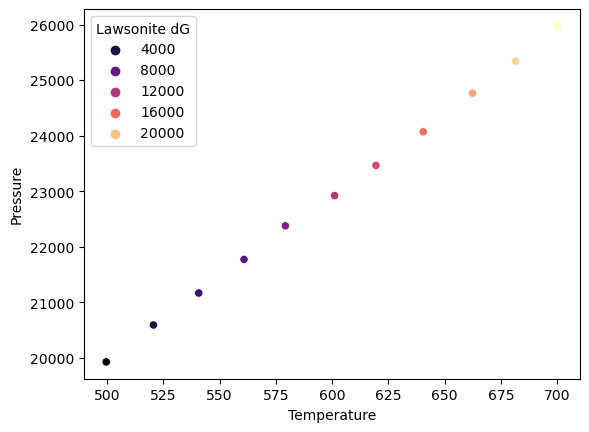

In [39]:
fig, axs = plt.subplots()

# sns.scatterplot(data=laws_in_MORB_fractionated, x="Temperature", y="Pressure", palette="mako_r", hue="Lawsonite vol %", ax=axs)
sns.scatterplot(data=laws_in_MORB_fractionated, x="Temperature", y="Pressure", palette="magma", hue="Lawsonite dG", ax=axs)